In [10]:
from fbm_dropout.net import DenseNet, DenseNetFBM
import torch.optim as optim
import torch.nn as nn

hidden_sizes = [1024, 1024]
device='cuda'

model = DenseNet(hidden_sizes, [0, 0], device=device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

model_dropout = DenseNet(hidden_sizes, [0, .2], device=device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [11]:
import torch
from fbm_dropout.dataset import get_MNIST_dataset
import numpy as np

trainset, testset = get_MNIST_dataset('~/dataset')
idx = torch.randint(0, 60000, (20000,)).tolist()
trainset = torch.utils.data.Subset(trainset, idx)
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [12]:
results = {}
results['train loss'] = {}
results['train loss']['no dropout'] = []
results['train loss']['dropout'] = []

results['test loss'] = {}
results['test loss']['no dropout'] = []
results['test loss']['dropout'] = []

results['test acc'] = {}
results['test acc']['no dropout'] = []
results['test acc']['dropout'] = []

results['num wrong'] = {}
results['num wrong']['no dropout'] = []
results['num wrong']['dropout'] = []

for epoch in range(100):
    model.train()
    model_dropout.train()

    running_loss = {}
    running_loss['no dropout'] = running_loss['dropout'] = running_loss['fbm dropout'] = 0.0
    for images, labels in train_loader:

        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        optimizer_dropout.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss['no dropout'] += loss.item()

        output_dropout = model_dropout(images)
        loss_dropout = criterion(output_dropout, labels)
        loss_dropout.backward()
        optimizer_dropout.step()
        running_loss['dropout'] += loss_dropout.item()

    results['train loss']['no dropout'].append(running_loss['no dropout'] / len(train_loader))
    results['train loss']['dropout'].append(running_loss['dropout'] / len(train_loader))

    model.eval()
    model_dropout.eval()
    acc = acc_dropout = 0.0
    running_loss['no dropout'] = running_loss['dropout'] = running_loss['fbm dropout'] = 0.0
    results['num wrong']['no dropout'].append(0)
    results['num wrong']['dropout'].append(0)
    for images, labels in test_loader:
        images = images.view(-1,784).to(device)
        labels = labels.to(device)
        output = model(images)
        _, pred = torch.max(output, axis=1)
        results['num wrong']['no dropout'][-1] += torch.sum(pred != labels).item()
        acc += torch.sum(pred==labels).item()
        running_loss['no dropout'] += criterion(output, labels).item()

        output_dropout = model_dropout(images)
        _, pred_dropout = torch.max(output_dropout, axis=1)
        results['num wrong']['dropout'][-1] += torch.sum(pred_dropout != labels).item()
        acc_dropout += torch.sum(pred_dropout==labels).item()
        running_loss['dropout'] += criterion(output_dropout, labels).item()

    results['test loss']['no dropout'].append(running_loss['no dropout'] / len(train_loader))
    results['test loss']['dropout'].append(running_loss['dropout'] / len(train_loader))
    
    results['test acc']['no dropout'].append(acc / len(testset))
    results['test acc']['dropout'].append(acc_dropout / len(testset))

    print('Epoch {}'.format(epoch))
    print('No Dropout : Train Loss {:.4f}, Test Acc {:.4f}'.format(results['train loss']['no dropout'][-1], results['test acc']['no dropout'][-1]))
    print('Dropout    : Train Loss {:.4f}, Test Acc {:.4f}'.format(results['train loss']['dropout'][-1], results['test acc']['dropout'][-1]))

Epoch 0
No Dropout : Train Loss 2.2377, Test Acc 0.4936
Dropout    : Train Loss 2.2420, Test Acc 0.3836
Epoch 1
No Dropout : Train Loss 2.0973, Test Acc 0.6300
Dropout    : Train Loss 2.1229, Test Acc 0.5709
Epoch 2
No Dropout : Train Loss 1.9269, Test Acc 0.6775
Dropout    : Train Loss 1.9708, Test Acc 0.6399
Epoch 3
No Dropout : Train Loss 1.7145, Test Acc 0.7347
Dropout    : Train Loss 1.7775, Test Acc 0.7089
Epoch 4
No Dropout : Train Loss 1.4781, Test Acc 0.7585
Dropout    : Train Loss 1.5544, Test Acc 0.7366
Epoch 5
No Dropout : Train Loss 1.2545, Test Acc 0.7878
Dropout    : Train Loss 1.3402, Test Acc 0.7760
Epoch 6
No Dropout : Train Loss 1.0700, Test Acc 0.8048
Dropout    : Train Loss 1.1544, Test Acc 0.7925
Epoch 7
No Dropout : Train Loss 0.9288, Test Acc 0.8243
Dropout    : Train Loss 1.0095, Test Acc 0.8106
Epoch 8
No Dropout : Train Loss 0.8224, Test Acc 0.8361
Dropout    : Train Loss 0.8997, Test Acc 0.8261
Epoch 9
No Dropout : Train Loss 0.7424, Test Acc 0.8431
Dropout 

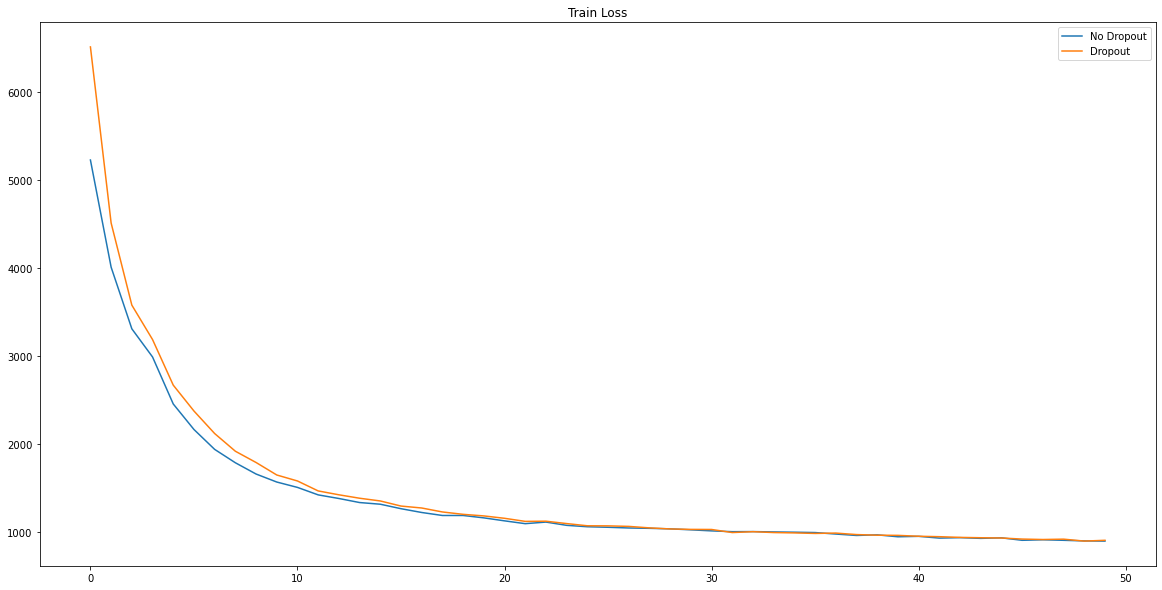

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(results['num wrong']['no dropout'], label='No Dropout')
plt.plot(results['num wrong']['dropout'], label='Dropout')
plt.title('Train Loss')
plt.legend()
plt.show()